# Statistical analysis, forecasting and Dashboard

In [1]:
# Suppress the warnings
import warnings
warnings.filterwarnings('ignore')

from statsmodels.tools.sm_exceptions import ValueWarning
warnings.simplefilter('ignore', ValueWarning)

In [2]:
#import required libraries

import pandas as pd
import os
import numpy as np
from numpy import sqrt
from numpy import mean
from matplotlib import pyplot as plt
import seaborn as sns
from datetime import datetime
from datetime import date, timedelta
from dateutil.relativedelta import relativedelta
from pandas import DataFrame
from pandas.plotting import lag_plot
from pandas.plotting import autocorrelation_plot
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_predict
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.arima.model import ARIMA
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error
from tabulate import tabulate
import statsmodels.api as sm
from scipy.stats import shapiro
from scipy import stats
import pingouin as pg
import textwrap
import dash
from dash import dcc,html
from dash.dependencies import Input, Output
import plotly.express as px

In [3]:
def wrap_labels(ax, width, break_long_words=False):
    labels = []
    for label in ax.get_xticklabels():
        text = label.get_text()
        labels.append(textwrap.fill(text, width=width,
                      break_long_words=break_long_words))
    ax.set_xticklabels(labels, rotation=0)

In [4]:
path = os.getcwd()
irish_costs = pd.read_csv(path + "/irish_costs.csv")
irish_costs.pop('Unnamed: 0')

0        0
1        1
2        2
3        3
4        4
      ... 
507    507
508    508
509    509
510    510
511    511
Name: Unnamed: 0, Length: 512, dtype: int64

In [5]:
irish_costs.head()

,Month,UNIT,House Construction Cost Index
0,197501,Base Jan 1991=100,18.3
1,197502,Base Jan 1991=100,18.7
2,197503,Base Jan 1991=100,18.8
3,197504,Base Jan 1991=100,19.6
4,197505,Base Jan 1991=100,19.8


## Forecasting Irish construction costs

In [6]:
#Make the Month variable a datetime object
for i in range(0,len(irish_costs.Month)):
    irish_costs.Month[i] = pd.to_datetime(irish_costs.Month[i],format='%Y%m')

In [7]:
irish_costs["Month"] = irish_costs["Month"].values.astype('datetime64[M]')

In [8]:
irish_costs.head()

,Month,UNIT,House Construction Cost Index
0,1975-01-01,Base Jan 1991=100,18.3
1,1975-02-01,Base Jan 1991=100,18.7
2,1975-03-01,Base Jan 1991=100,18.8
3,1975-04-01,Base Jan 1991=100,19.6
4,1975-05-01,Base Jan 1991=100,19.8


In [9]:
irish_costs.set_index('Month', inplace=True)

In [10]:
irish_costs.tail()

,UNIT,House Construction Cost Index
Month,,
2017-04-01,Base Jan 1991=100,210.7
2017-05-01,Base Jan 1991=100,211.1
2017-06-01,Base Jan 1991=100,211.2
2017-07-01,Base Jan 1991=100,211.4
2017-08-01,Base Jan 1991=100,211.4


In [11]:
irish_costs.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 512 entries, 1975-01-01 to 2017-08-01
Data columns (total 2 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   UNIT                           512 non-null    object 
 1   House Construction Cost Index  512 non-null    float64
dtypes: float64(1), object(1)
memory usage: 12.0+ KB


In [12]:
irish_costs.describe()

,House Construction Cost Index
count,512.000000
mean,126.052344
std,63.650513
min,18.300000
25%,78.800000
50%,115.900000
75%,198.275000
max,211.400000


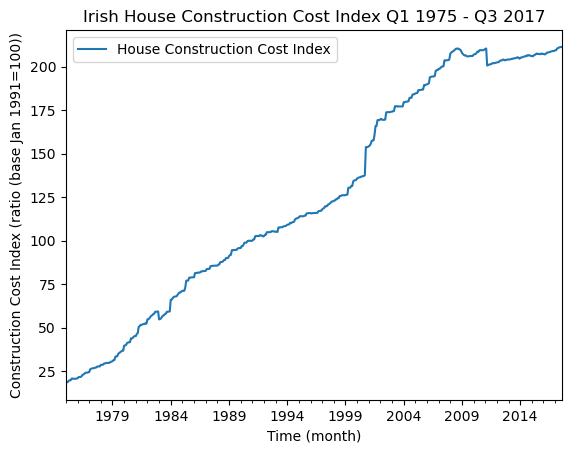

In [13]:
irish_costs.plot()
plt.xlabel("Time (month)")
plt.ylabel("Construction Cost Index (ratio (base Jan 1991=100))")
plt.title("Irish House Construction Cost Index Q1 1975 - Q3 2017")
plt.xlim(min(irish_costs.index), max(irish_costs.index))
plt.show()

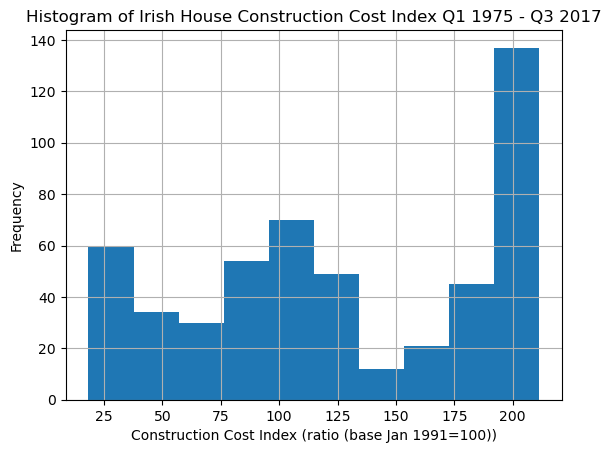

In [14]:
irish_costs.hist()
plt.ylabel("Frequency")
plt.xlabel("Construction Cost Index (ratio (base Jan 1991=100))")
plt.title("Histogram of Irish House Construction Cost Index Q1 1975 - Q3 2017")
plt.show()

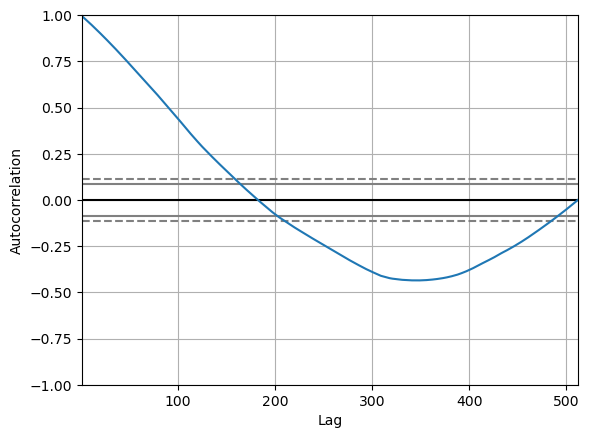

In [15]:
autocorrelation_plot(irish_costs["House Construction Cost Index"])
plt.show()

### Time-series and autocorrelation plots

<function matplotlib.pyplot.show(close=None, block=None)>

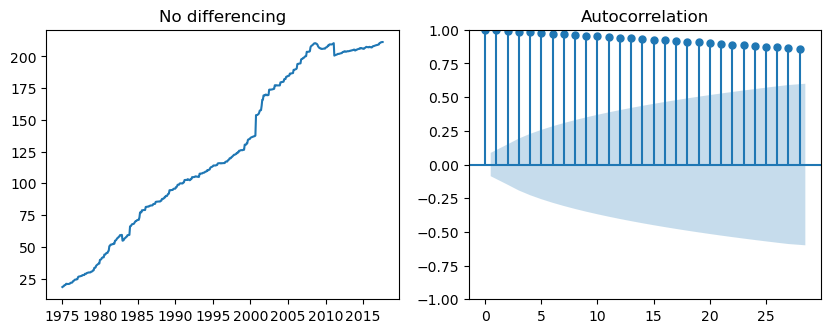

In [16]:
#No differencing
f = plt.figure(figsize=(10,3.5))
ax1 = f.add_subplot(121)
ax1.set_title("No differencing")
ax1.plot(irish_costs["House Construction Cost Index"])

ax2 = f.add_subplot(122)
plot_acf(irish_costs["House Construction Cost Index"], ax=ax2)

plt.show

<function matplotlib.pyplot.show(close=None, block=None)>

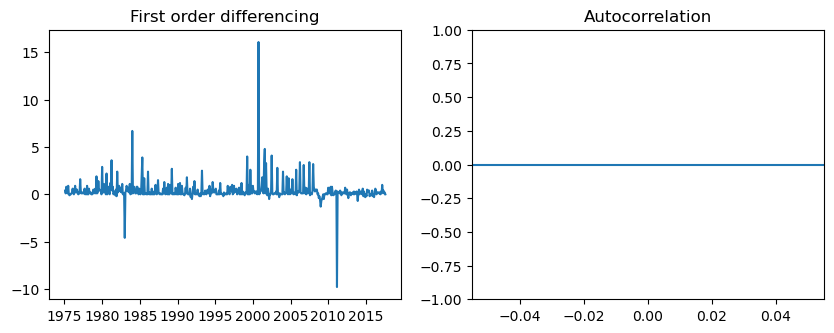

In [17]:
# 1st order differencing
f = plt.figure(figsize=(10,3.5))
ax1 = f.add_subplot(121)
ax1.set_title("First order differencing")
ax1.plot(irish_costs["House Construction Cost Index"].diff())

ax2 = f.add_subplot(122)
plot_acf(irish_costs["House Construction Cost Index"].diff(), ax=ax2)

plt.show

<function matplotlib.pyplot.show(close=None, block=None)>

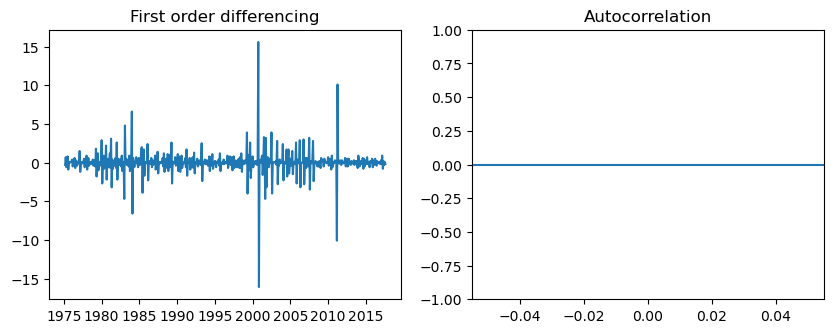

In [18]:
# 2nd order differencing
f = plt.figure(figsize=(10,3.5))
ax1 = f.add_subplot(121)
ax1.set_title("First order differencing")
ax1.plot(irish_costs["House Construction Cost Index"].diff().diff())

ax2 = f.add_subplot(122)
plot_acf(irish_costs["House Construction Cost Index"].diff().diff(), ax=ax2)

plt.show

### Dickey-Fuller Tests

In [19]:
#No differencing
result = adfuller(irish_costs["House Construction Cost Index"])

print('ADF Statistic: {}'.format(result[0]))
print('p-value: {}'.format(result[1]))
print('Critical Values:')
for key, value in result[4].items():
    print('\t{}: {}'.format(key, value))

ADF Statistic: -1.334518628441303
p-value: 0.6132358231873973
Critical Values:
	1%: -3.443470002903981
	5%: -2.867326248740681
	10%: -2.569851849873108


In [20]:
# 1st order differencing

result = adfuller(irish_costs["House Construction Cost Index"].diff().dropna())

print('ADF Statistic: {}'.format(result[0]))
print('p-value: {}'.format(result[1]))
print('Critical Values:')
for key, value in result[4].items():
    print('\t{}: {}'.format(key, value))

ADF Statistic: -5.167997055093804
p-value: 1.0215790494176466e-05
Critical Values:
	1%: -3.443470002903981
	5%: -2.867326248740681
	10%: -2.569851849873108


In [21]:
# 2nd order differencing

result = adfuller(irish_costs["House Construction Cost Index"].diff().diff().dropna())

print('ADF Statistic: {}'.format(result[0]))
print('p-value: {}'.format(result[1]))
print('Critical Values:')
for key, value in result[4].items():
    print('\t{}: {}'.format(key, value))

ADF Statistic: -8.381323059525727
p-value: 2.505572471992689e-13
Critical Values:
	1%: -3.4437660979098843
	5%: -2.8674565460819896
	10%: -2.569921291128696


### ARIMA Model fit

In [22]:
### Fit ARIMA Model

model = ARIMA(irish_costs["House Construction Cost Index"], order=(50,2,0))
model_fit = model.fit()

# summary of fit model
print(model_fit.summary())

                                     SARIMAX Results                                     
Dep. Variable:     House Construction Cost Index   No. Observations:                  512
Model:                           ARIMA(50, 2, 0)   Log Likelihood                -768.170
Date:                           Sun, 21 May 2023   AIC                           1638.340
Time:                                   17:08:53   BIC                           1854.295
Sample:                               01-01-1975   HQIC                          1723.009
                                    - 08-01-2017                                         
Covariance Type:                             opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.9770      0.122     -8.041      0.000      -1.215      -0.739
ar.L2         -0.9507      0.153     -6.229

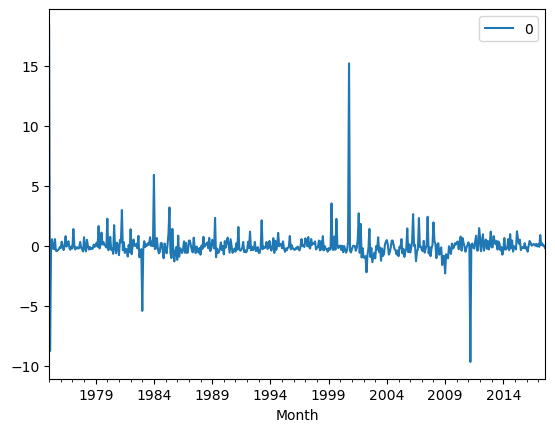

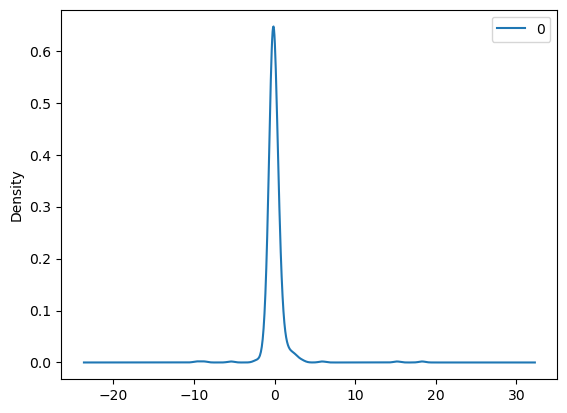

                0
count  512.000000
mean     0.013493
std      1.408703
min     -9.659031
25%     -0.354548
50%     -0.129758
75%      0.222038
max     18.300000


In [23]:
# line plot of residuals
residuals = DataFrame(model_fit.resid)
residuals.plot()
plt.show()

#density plot of residuals
residuals.plot(kind='kde')
plt.show()

#summary stats of residuals showing mean ~= 0.
print(residuals.describe())

### Time-series cross-validation

In [24]:
tscv = TimeSeriesSplit(n_splits = 10)
rmse = []
for train_index, test_index in tscv.split(irish_costs):
    cv_train, cv_test = irish_costs.iloc[train_index], irish_costs.iloc[test_index]
    model = ARIMA(cv_train["House Construction Cost Index"], order=(50, 2, 0)).fit()
    predictions = model.predict(cv_test.index.values[0], cv_test.index.values[-1])
    true_values = cv_test["House Construction Cost Index"]
    rmse.append(np.sqrt(mean_squared_error(true_values, predictions)))

print(rmse)

print(np.mean(rmse))

/home/ciara/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


[12.930376842652896, 13.480251902508249, 3.1689753654521886, 3.0741926849590127, 2.1389116704514657, 17.329695123874725, 13.613194682773107, 5.004996265481262, 7.649558183510124, 1.5838632274312259]
7.997401594909425


In [25]:
#create data
data = [["ARIMA(order=(50,1,0))", 8.5],
        ["ARIMA(order=(50,1,1))", 8.7],
        ["ARIMA(order=(50,2,0))", 8.0], 
        ["ARIMA(order=(50,2,1))", 9.0], 
        ["ARIMA(order=(30,2,0))", 9.1], 
        ["ARIMA(order=(40,2,0))", 11.2]]
  
#define header names
col_names = ["ARIMA (order=(p,d,q))", "RMSE"]
  
#display table
print(tabulate(data, headers=col_names))

ARIMA (order=(p,d,q))      RMSE
-----------------------  ------
ARIMA(order=(50,1,0))       8.5
ARIMA(order=(50,1,1))       8.7
ARIMA(order=(50,2,0))       8
ARIMA(order=(50,2,1))       9
ARIMA(order=(30,2,0))       9.1
ARIMA(order=(40,2,0))      11.2


In [26]:
# split into train and test sets
X = irish_costs["House Construction Cost Index"]
size = int(len(X) * 0.66)
train, test = X[0:size], X[size:len(X)]
history = [x for x in train]
predictions = list()

train, test

(Month
 1975-01-01     18.3
 1975-02-01     18.7
 1975-03-01     18.8
 1975-04-01     19.6
 1975-05-01     19.8
               ...  
 2002-09-01    173.9
 2002-10-01    173.9
 2002-11-01    174.0
 2002-12-01    174.1
 2003-01-01    174.2
 Name: House Construction Cost Index, Length: 337, dtype: float64,
 Month
 2003-02-01    174.5
 2003-03-01    174.5
 2003-04-01    177.3
 2003-05-01    177.3
 2003-06-01    177.4
               ...  
 2017-04-01    210.7
 2017-05-01    211.1
 2017-06-01    211.2
 2017-07-01    211.4
 2017-08-01    211.4
 Name: House Construction Cost Index, Length: 175, dtype: float64)

In [27]:
model_test = ARIMA(history, order=(50,2,0))
model_test_fit = model_test.fit()
output_test = model_test_fit.forecast(len(test))

In [28]:
predictions=[]
# walk-forward validation
for t in range(len(test)):
    yhat = output_test[t]
    predictions.append(yhat)
    obs = test[test.index[t]]
    history.append(obs)
    print('predicted=%f, expected=%f' % (yhat, obs))

predicted=173.419990, expected=174.500000
predicted=173.061709, expected=174.500000
predicted=175.206673, expected=177.300000
predicted=176.123641, expected=177.300000
predicted=175.669016, expected=177.400000
predicted=176.648465, expected=177.100000
predicted=176.252833, expected=177.200000
predicted=177.784443, expected=177.200000
predicted=178.837359, expected=177.200000
predicted=178.617281, expected=177.200000
predicted=178.447132, expected=177.200000
predicted=180.569948, expected=179.600000
predicted=179.738072, expected=179.700000
predicted=182.402906, expected=179.900000
predicted=182.750936, expected=179.900000
predicted=183.068559, expected=180.000000
predicted=183.835225, expected=180.200000
predicted=185.252858, expected=182.100000
predicted=185.210915, expected=182.200000
predicted=186.111826, expected=182.200000
predicted=190.113084, expected=183.900000
predicted=191.809753, expected=184.200000
predicted=192.418877, expected=184.200000
predicted=194.197120, expected=184

In [29]:
test.head(), test.tail()

(Month
 2003-02-01    174.5
 2003-03-01    174.5
 2003-04-01    177.3
 2003-05-01    177.3
 2003-06-01    177.4
 Name: House Construction Cost Index, dtype: float64,
 Month
 2017-04-01    210.7
 2017-05-01    211.1
 2017-06-01    211.2
 2017-07-01    211.4
 2017-08-01    211.4
 Name: House Construction Cost Index, dtype: float64)

In [30]:
start_dt = date(2003, 2, 1)
end_dt = date(2017, 8, 1)

dates = []

while start_dt <= end_dt:
    # add current date to list by converting  it to iso format
    dates.append(start_dt.isoformat())
    # increment start date by timedelta
    start_dt += relativedelta(months=1)

In [31]:
predictions

[173.41998957356375,
 173.06170850887912,
 175.20667342882498,
 176.1236410751471,
 175.66901609968303,
 176.64846466954683,
 176.25283300236967,
 177.78444251125111,
 178.8373589776298,
 178.61728091999353,
 178.44713182970577,
 180.5699483133747,
 179.73807243235794,
 182.40290573281334,
 182.75093563734296,
 183.0685588958751,
 183.8352248101858,
 185.2528577045593,
 185.210915305602,
 186.11182559945422,
 190.11308433281621,
 191.8097533041046,
 192.41887686778165,
 194.19712036379042,
 193.94446292025813,
 195.00256895714975,
 196.8110862736304,
 196.81112547257592,
 197.49993241663194,
 199.6405713398549,
 201.03513095782273,
 202.5301180921805,
 204.43762784177696,
 204.69274049483735,
 205.70931657695672,
 206.59971341483987,
 206.83018396229528,
 207.38883664202842,
 208.64545338931674,
 208.70094132026028,
 209.48532641703056,
 211.34864670735513,
 212.1781117165846,
 212.75781779411585,
 213.79871968588063,
 213.66330658585812,
 214.68843669458172,
 215.2998963564122,
 215.2

In [32]:
len(predictions), len(test)

(175, 175)

In [33]:
predictions_df = pd.DataFrame(list(zip(dates,predictions)), columns = ["Month", "Predicted Index"])

In [34]:
predictions_df["Month"] = predictions_df["Month"].values.astype('datetime64[M]')

In [35]:
predictions_df.set_index('Month', inplace=True)

In [36]:
predictions_df

,Predicted Index
Month,
2003-02-01,173.419990
2003-03-01,173.061709
2003-04-01,175.206673
2003-05-01,176.123641
2003-06-01,175.669016
...,...
2017-04-01,318.493245
2017-05-01,319.283582
2017-06-01,320.269100


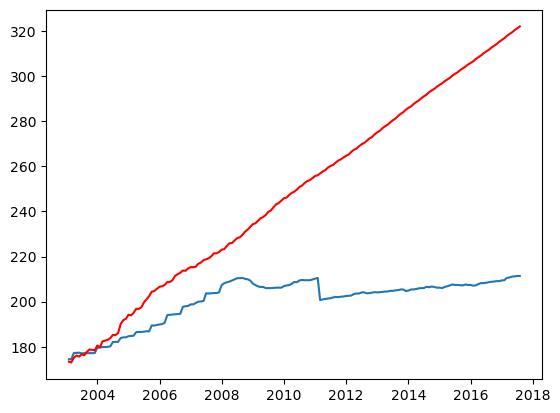

In [37]:
plt.plot(test)
plt.plot(predictions_df, color='red')
plt.show()

### Forecast costs beyond August 2017

In [38]:
# Irish social housing construction data goes to Q4 (december) 2021
# To forecast the cost data until this date requires 4 years ad 4 months of predictions (Dec. 2021 - Aug. 2017)
output = model_fit.forecast(4 * 12 + 4)
output.head()

2017-09-01    211.542202
2017-10-01    211.707108
2017-11-01    211.882778
2017-12-01    212.001782
2018-01-01    212.285052
Freq: MS, Name: predicted_mean, dtype: float64

In [39]:
future_predictions = output.to_frame()

In [40]:
future_predictions.head()

,predicted_mean
2017-09-01,211.542202
2017-10-01,211.707108
2017-11-01,211.882778
2017-12-01,212.001782
2018-01-01,212.285052


In [41]:
future_predictions.columns=['House Construction Cost Index']

In [42]:
future_predictions.tail()

,House Construction Cost Index
2021-08-01,219.630345
2021-09-01,219.786910
2021-10-01,219.956014
2021-11-01,220.120847
2021-12-01,220.287292


In [43]:
irish_costs.head()

,UNIT,House Construction Cost Index
Month,,
1975-01-01,Base Jan 1991=100,18.3
1975-02-01,Base Jan 1991=100,18.7
1975-03-01,Base Jan 1991=100,18.8
1975-04-01,Base Jan 1991=100,19.6
1975-05-01,Base Jan 1991=100,19.8


In [44]:
irish_costs.tail()

,UNIT,House Construction Cost Index
Month,,
2017-04-01,Base Jan 1991=100,210.7
2017-05-01,Base Jan 1991=100,211.1
2017-06-01,Base Jan 1991=100,211.2
2017-07-01,Base Jan 1991=100,211.4
2017-08-01,Base Jan 1991=100,211.4


In [45]:
len(future_predictions)

52

In [46]:
len(irish_costs)

512

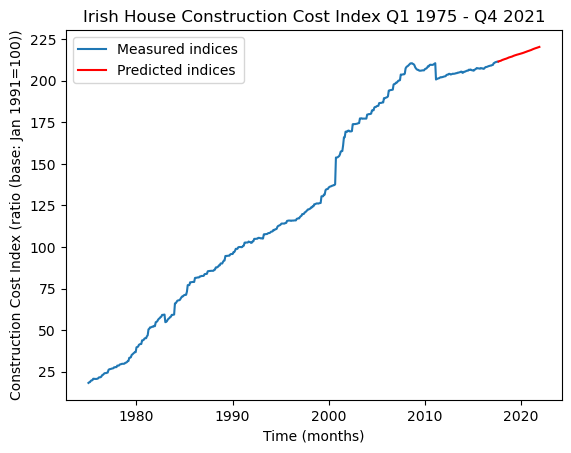

In [47]:
# plot forecasts against actual outcomes
plt.plot(irish_costs["House Construction Cost Index"])
plt.plot(future_predictions, color='red')
plt.xlabel("Time (months)")
plt.ylabel("Construction Cost Index (ratio (base: Jan 1991=100))")
plt.title("Irish House Construction Cost Index Q1 1975 - Q4 2021")
plt.legend(['Measured indices', 'Predicted indices'])
plt.show()

In [48]:
irish_costs_incl_forecast = pd.concat([irish_costs, future_predictions])

In [49]:
len(irish_costs_incl_forecast)

564

In [50]:
irish_costs_incl_forecast.head()

,UNIT,House Construction Cost Index
1975-01-01,Base Jan 1991=100,18.3
1975-02-01,Base Jan 1991=100,18.7
1975-03-01,Base Jan 1991=100,18.8
1975-04-01,Base Jan 1991=100,19.6
1975-05-01,Base Jan 1991=100,19.8


In [51]:
irish_costs_incl_forecast.tail()

,UNIT,House Construction Cost Index
2021-08-01,NaN,219.630345
2021-09-01,NaN,219.786910
2021-10-01,NaN,219.956014
2021-11-01,NaN,220.120847
2021-12-01,NaN,220.287292


In [52]:
#Create a Quarter variable in same format as completion data dataframe
irish_costs_incl_forecast["Quarter"] = " "
irish_costs_incl_forecast["Year"] = " "
for i in range(0,len(irish_costs_incl_forecast.index)):
    year=irish_costs_incl_forecast.index[i].year
    month=irish_costs_incl_forecast.index[i].month
    irish_costs_incl_forecast["Year"][i] = year
    try:
        if month >= 1 and month <= 3:
            irish_costs_incl_forecast["Quarter"][i] = (f"q1_{year}")
        elif month >= 4 and month <= 6:
            irish_costs_incl_forecast["Quarter"][i] = (f"q2_{year}")
        elif month >= 7 and month <= 9:
            irish_costs_incl_forecast["Quarter"][i] = (f"q3_{year}")
        elif month >= 10 and month <= 12:
            irish_costs_incl_forecast["Quarter"][i] = (f"q4_{year}")
    except:
        print("Month format does not match.")

In [53]:
irish_costs_incl_forecast.head()

,UNIT,House Construction Cost Index,Quarter,Year
1975-01-01,Base Jan 1991=100,18.3,q1_1975,1975
1975-02-01,Base Jan 1991=100,18.7,q1_1975,1975
1975-03-01,Base Jan 1991=100,18.8,q1_1975,1975
1975-04-01,Base Jan 1991=100,19.6,q2_1975,1975
1975-05-01,Base Jan 1991=100,19.8,q2_1975,1975


In [54]:
irish_costs_incl_forecast.tail()

,UNIT,House Construction Cost Index,Quarter,Year
2021-08-01,NaN,219.630345,q3_2021,2021
2021-09-01,NaN,219.786910,q3_2021,2021
2021-10-01,NaN,219.956014,q4_2021,2021
2021-11-01,NaN,220.120847,q4_2021,2021
2021-12-01,NaN,220.287292,q4_2021,2021


## Read the irish social housing construction data

In [55]:
irish_completed_social_housing = pd.read_csv(path + "/irish_completed_social_housing.csv")
irish_completed_social_housing.pop('Unnamed: 0')

0        0
1        1
2        2
3        3
4        4
      ... 
432    339
433    340
434    341
435    342
436    343
Name: Unnamed: 0, Length: 437, dtype: int64

In [56]:
irish_completed_social_housing.head()

,Quarter,Local Authority,No. of Units,Year
0,q1_2018,Carlow,374.0,2018
1,q1_2018,Cavan,55.0,2018
2,q1_2018,Clare,212.0,2018
3,q1_2018,Cork City,873.0,2018
4,q1_2018,Cork County,765.0,2018


In [57]:
irish_completed_social_housing.tail()

,Quarter,Local Authority,No. of Units,Year
432,q4-2021,Tipperary,811.0,2021
433,q4-2021,Waterford,947.0,2021
434,q4-2021,Westmeath,981.0,2021
435,q4-2021,Wexford,1234.0,2021
436,q4-2021,Wicklow,1825.0,2021


In [58]:
irish_completed_social_housing_by_year = irish_completed_social_housing.groupby(['Year'],as_index=False).sum()

In [59]:
irish_completed_social_housing_by_year.head()

,Year,No. of Units
0,2018,67837.0
1,2019,91199.0
2,2020,95487.0
3,2021,112909.0


In [60]:
irish_completed_social_housing_no_LA = irish_completed_social_housing.groupby(['Quarter'],as_index=False).sum()

In [61]:
irish_completed_social_housing_no_LA.pop("Year")

0     64576
1     62589
2     62651
3     66594
4     62589
5     62620
6     62558
7     62589
8     62620
9     62651
10    62651
11    62558
12    62589
13    62620
Name: Year, dtype: int64

In [62]:
irish_completed_social_housing_no_LA

,Quarter,No. of Units
0,q1_2018,14816.0
1,q1_2019,20324.0
2,q1_2021,34511.0
3,q2_2018,16351.0
4,q2_2019,22139.0
5,q2_2020,29810.0
6,q3_2018,17536.0
7,q3_2019,22721.0
8,q3_2020,31862.0
9,q3_2021,38174.0


## Basic visualisations

### Check if no. of units built per quarter in Irish dataset is normally distributed

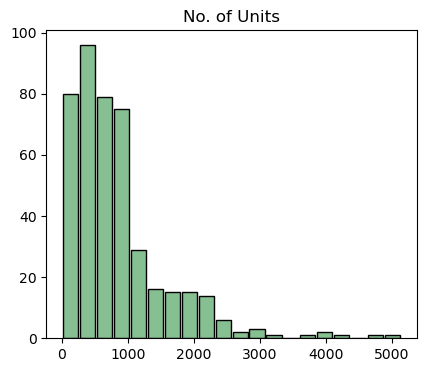

In [63]:
#Histogram
ax = irish_completed_social_housing.hist(column='No. of Units', edgecolor='black', figsize=(11,4), bins= 20, grid=False, layout=(1,2), sharex=False, color='#86bf91', zorder=2, rwidth=0.9)

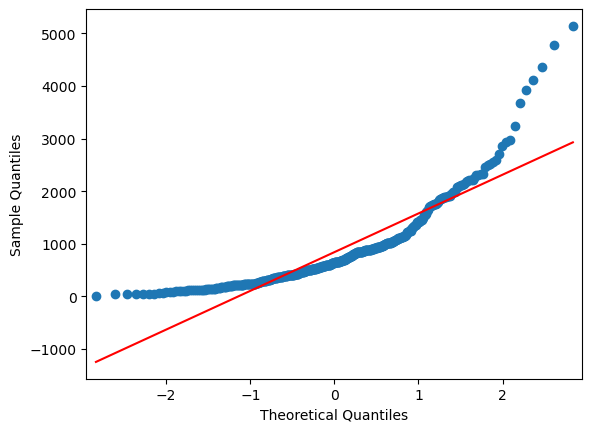

In [64]:
#Q-Q Plot
sm.qqplot(irish_completed_social_housing['No. of Units'], line='s')
plt.show()

In [65]:
#Shapiro-Wilk
#H0: The No. of Units built per quarter is normally distributed.

print(shapiro(irish_completed_social_housing['No. of Units']))

#ShapiroResult(statistic=0.8045326471328735, pvalue=1.3460487611434824e-22)
#Null-hypothesis is rejected

ShapiroResult(statistic=0.8045326471328735, pvalue=1.3460487611434824e-22)


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


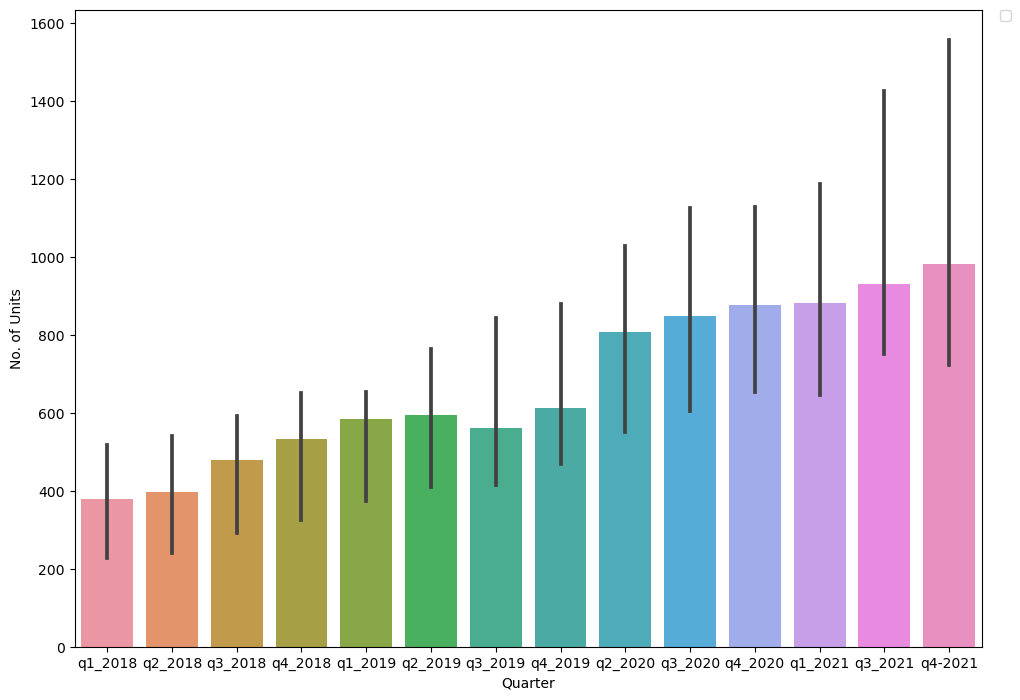

In [66]:
#Median central-tendency is used as data is non-parametric
a4_dims = (11.7, 11.7/sqrt(2))
fig, ax = plt.subplots(figsize=a4_dims)
ax=sns.barplot(x="Quarter", y="No. of Units", data=irish_completed_social_housing, estimator = np.median)
ax.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


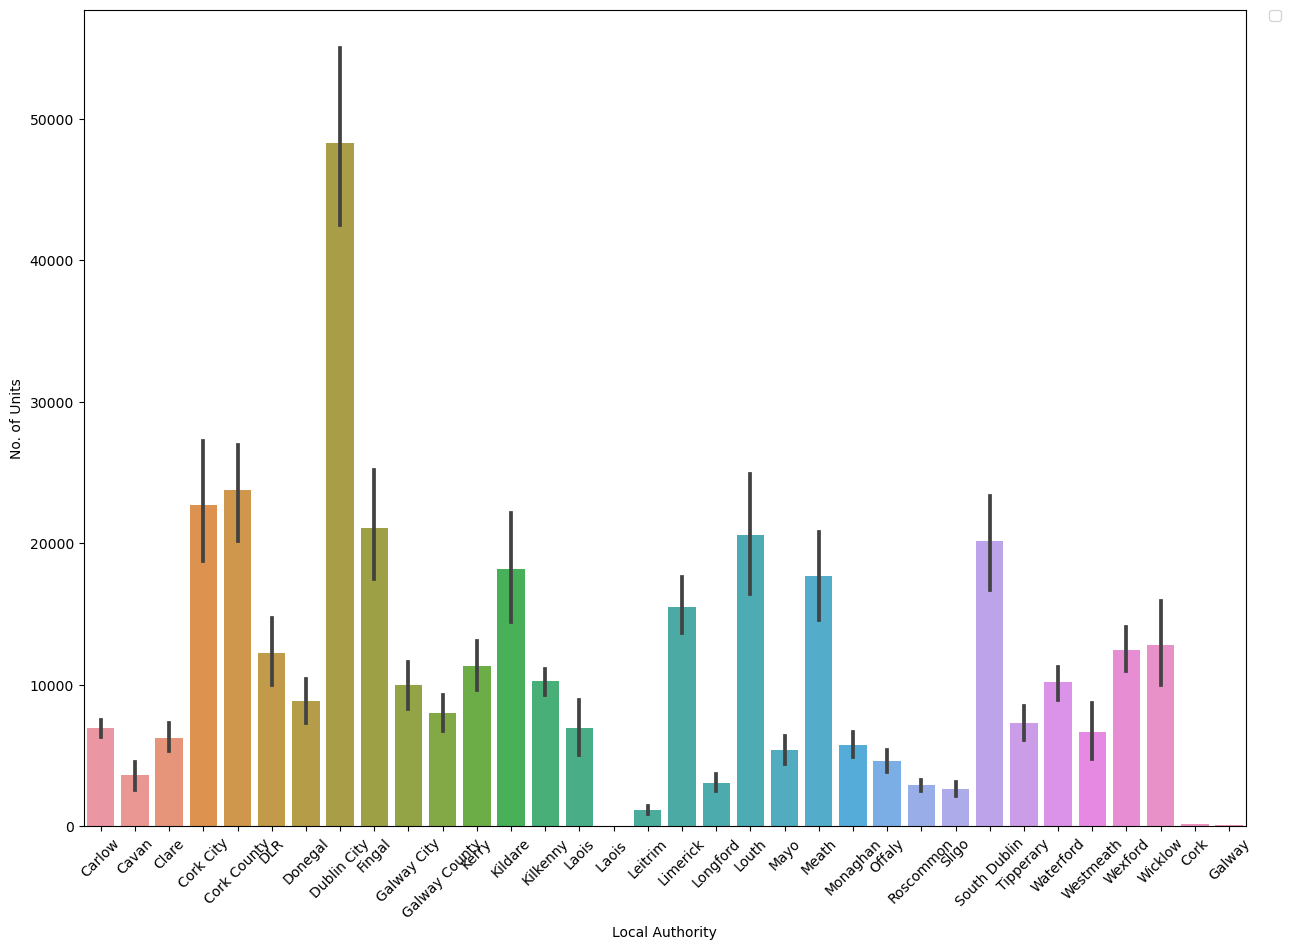

In [67]:
#Median central-tendency is used as data is non-parametric
a4_dims = (15, 15/sqrt(2))
fig, ax = plt.subplots(figsize=a4_dims)
ax=sns.barplot(x="Local Authority", y="No. of Units", data=irish_completed_social_housing, estimator = np.sum)
ax.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0)
for item in ax.get_xticklabels():
    item.set_rotation(45)

### Check if House Construction Cost in Irish dataset is normally distributed

In [68]:
irish_costs_incl_forecast.head()

,UNIT,House Construction Cost Index,Quarter,Year
1975-01-01,Base Jan 1991=100,18.3,q1_1975,1975
1975-02-01,Base Jan 1991=100,18.7,q1_1975,1975
1975-03-01,Base Jan 1991=100,18.8,q1_1975,1975
1975-04-01,Base Jan 1991=100,19.6,q2_1975,1975
1975-05-01,Base Jan 1991=100,19.8,q2_1975,1975


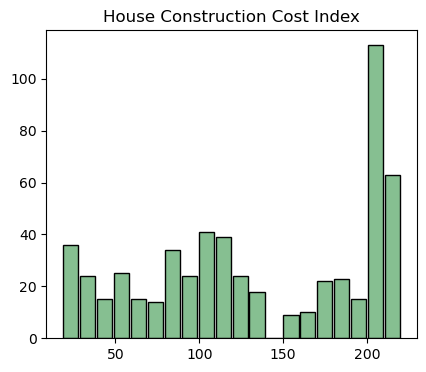

In [69]:
#Histogram
ax = irish_costs_incl_forecast.hist(column='House Construction Cost Index', edgecolor='black', figsize=(11,4), bins= 20, grid=False, layout=(1,2), sharex=False, color='#86bf91', zorder=2, rwidth=0.9)

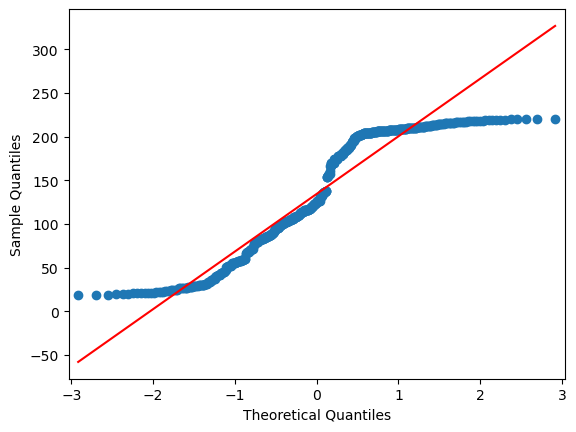

In [70]:
#Q-Q Plot
sm.qqplot(irish_costs_incl_forecast['House Construction Cost Index'], line='s')
plt.show()

In [71]:
#Shapiro-Wilk
#H0: The House Construction Cost Index per quarter is normally distributed.

print(shapiro(irish_costs_incl_forecast['House Construction Cost Index']))

#ShapiroResult(statistic=0.8969224691390991, pvalue=5.112611563685728e-19)
#Null-hypothesis is rejected

ShapiroResult(statistic=0.8969224691390991, pvalue=5.112611563685728e-19)


## Combining costs and completed buildings for the Irish data

In [72]:
irish_costs_incl_forecast.head()

,UNIT,House Construction Cost Index,Quarter,Year
1975-01-01,Base Jan 1991=100,18.3,q1_1975,1975
1975-02-01,Base Jan 1991=100,18.7,q1_1975,1975
1975-03-01,Base Jan 1991=100,18.8,q1_1975,1975
1975-04-01,Base Jan 1991=100,19.6,q2_1975,1975
1975-05-01,Base Jan 1991=100,19.8,q2_1975,1975


In [73]:
irish_costs_incl_forecast_by_quarter = irish_costs_incl_forecast.groupby(['Quarter'],as_index=False).median()

In [74]:
irish_costs_incl_forecast_by_quarter

,Quarter,House Construction Cost Index
0,q1_1975,18.700000
1,q1_1976,21.600000
2,q1_1977,26.100000
3,q1_1978,28.700000
4,q1_1979,31.400000
...,...,...
183,q4_2017,211.882778
184,q4_2018,214.087955
185,q4_2019,216.009245
186,q4_2020,217.960391


In [75]:
irish_completed_social_housing_no_LA.head()

,Quarter,No. of Units
0,q1_2018,14816.0
1,q1_2019,20324.0
2,q1_2021,34511.0
3,q2_2018,16351.0
4,q2_2019,22139.0


In [76]:
irish_data_combined = pd.merge(irish_costs_incl_forecast_by_quarter, irish_completed_social_housing_no_LA, on = "Quarter")

In [77]:
irish_data_combined.head()

,Quarter,House Construction Cost Index,No. of Units
0,q1_2018,212.513233,14816.0
1,q1_2019,214.525667,20324.0
2,q1_2021,218.490518,34511.0
3,q2_2018,213.003957,16351.0
4,q2_2019,215.117876,22139.0


## Visualisations

In [78]:
irish_data_combined.Quarter.unique()

array(['q1_2018', 'q1_2019', 'q1_2021', 'q2_2018', 'q2_2019', 'q2_2020',
       'q3_2018', 'q3_2019', 'q3_2020', 'q3_2021', 'q4_2018', 'q4_2019',
       'q4_2020'], dtype=object)

Text(0.5, 1.02, 'Pairplot of Finnish cost and completed buildings data')

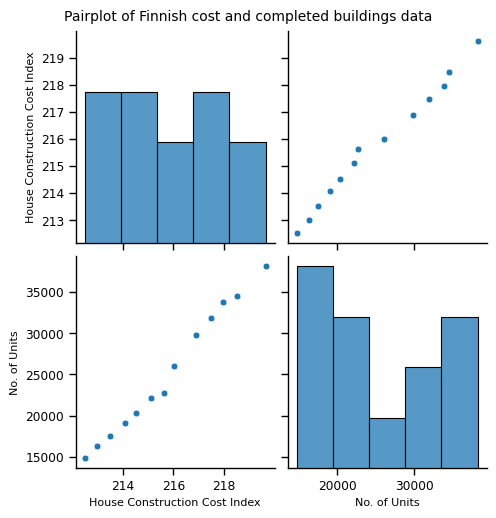

In [79]:
sns.set_context("paper", rc={"axes.labelsize":8})
g = sns.pairplot(irish_data_combined)
g.fig.suptitle("Pairplot of Finnish cost and completed buildings data", y=1.02, fontsize=10) # y= some height>1

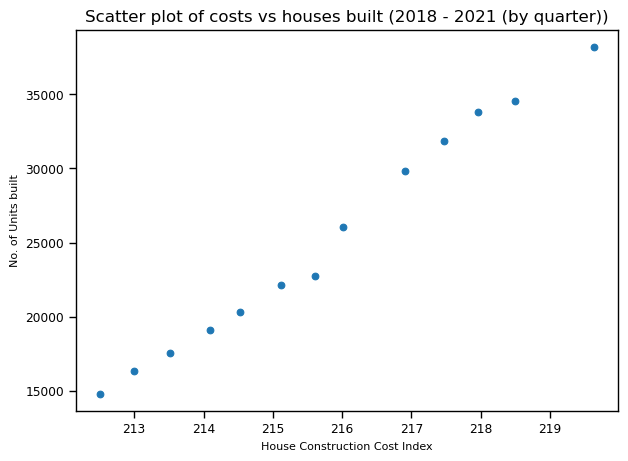

In [80]:
plt.figure(figsize=(7, 7/sqrt(2)))
plt.title("Scatter plot of costs vs houses built (2018 - 2021 (by quarter))", size=12)
plt.scatter(irish_data_combined["House Construction Cost Index"], irish_data_combined["No. of Units"])
plt.xlabel("House Construction Cost Index")
plt.ylabel("No. of Units built")
#plt.scatter(X_train, y_predicted, c="red")
plt.show()

## Read the Finnish data

In [81]:
finnish_completed_buildings = pd.read_csv(path + "/finnish_completed_buildings.csv")
finnish_completed_buildings.pop('Unnamed: 0')

finnish_costs = pd.read_csv(path + "/finnish_costs.csv")
finnish_costs.rename(columns={"Unnamed: 0": "Year"}, inplace=True)

In [82]:
finnish_completed_buildings.head()

,Year,Residential buildings completion (No.)
0,1995,24526
1,1996,21372
2,1997,26955
3,1998,30529
4,1999,30537


In [83]:
finnish_costs

,Year,Total,Labour,Materials,Services
0,1990,100.0,100.0,100.0,100.0
1,1991,102.2,108.4,98.3,102.5
2,1992,100.4,105.8,96.3,102.8
3,1993,100.7,105.0,98.6,99.0
4,1994,102.2,103.3,103.0,97.8
5,1995,103.5,103.0,105.3,99.1
6,1996,102.7,103.5,104.3,96.3
7,1997,105.2,106.9,107.2,96.8
8,1998,107.6,109.4,109.8,98.5
9,1999,109.1,113.5,110.2,99.0


## Combining costs and completed building for the Finnish datasets

In [84]:
finnish_data_combined = pd.merge(finnish_costs, finnish_completed_buildings, on = "Year")

In [85]:
finnish_data_combined.head()

,Year,Total,Labour,Materials,Services,Residential buildings completion (No.)
0,1995,103.5,103.0,105.3,99.1,24526
1,1996,102.7,103.5,104.3,96.3,21372
2,1997,105.2,106.9,107.2,96.8,26955
3,1998,107.6,109.4,109.8,98.5,30529
4,1999,109.1,113.5,110.2,99.0,30537


In [86]:
finnish_data_combined.Year.unique()

array([1995, 1996, 1997, 1998, 1999, 2000, 2001, 2002, 2003, 2004, 2005,
       2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016,
       2017, 2018, 2019, 2020, 2021, 2022])

## Visualisations

Text(0.5, 1.02, 'Pairplot of Finnish cost and completed buildings data')

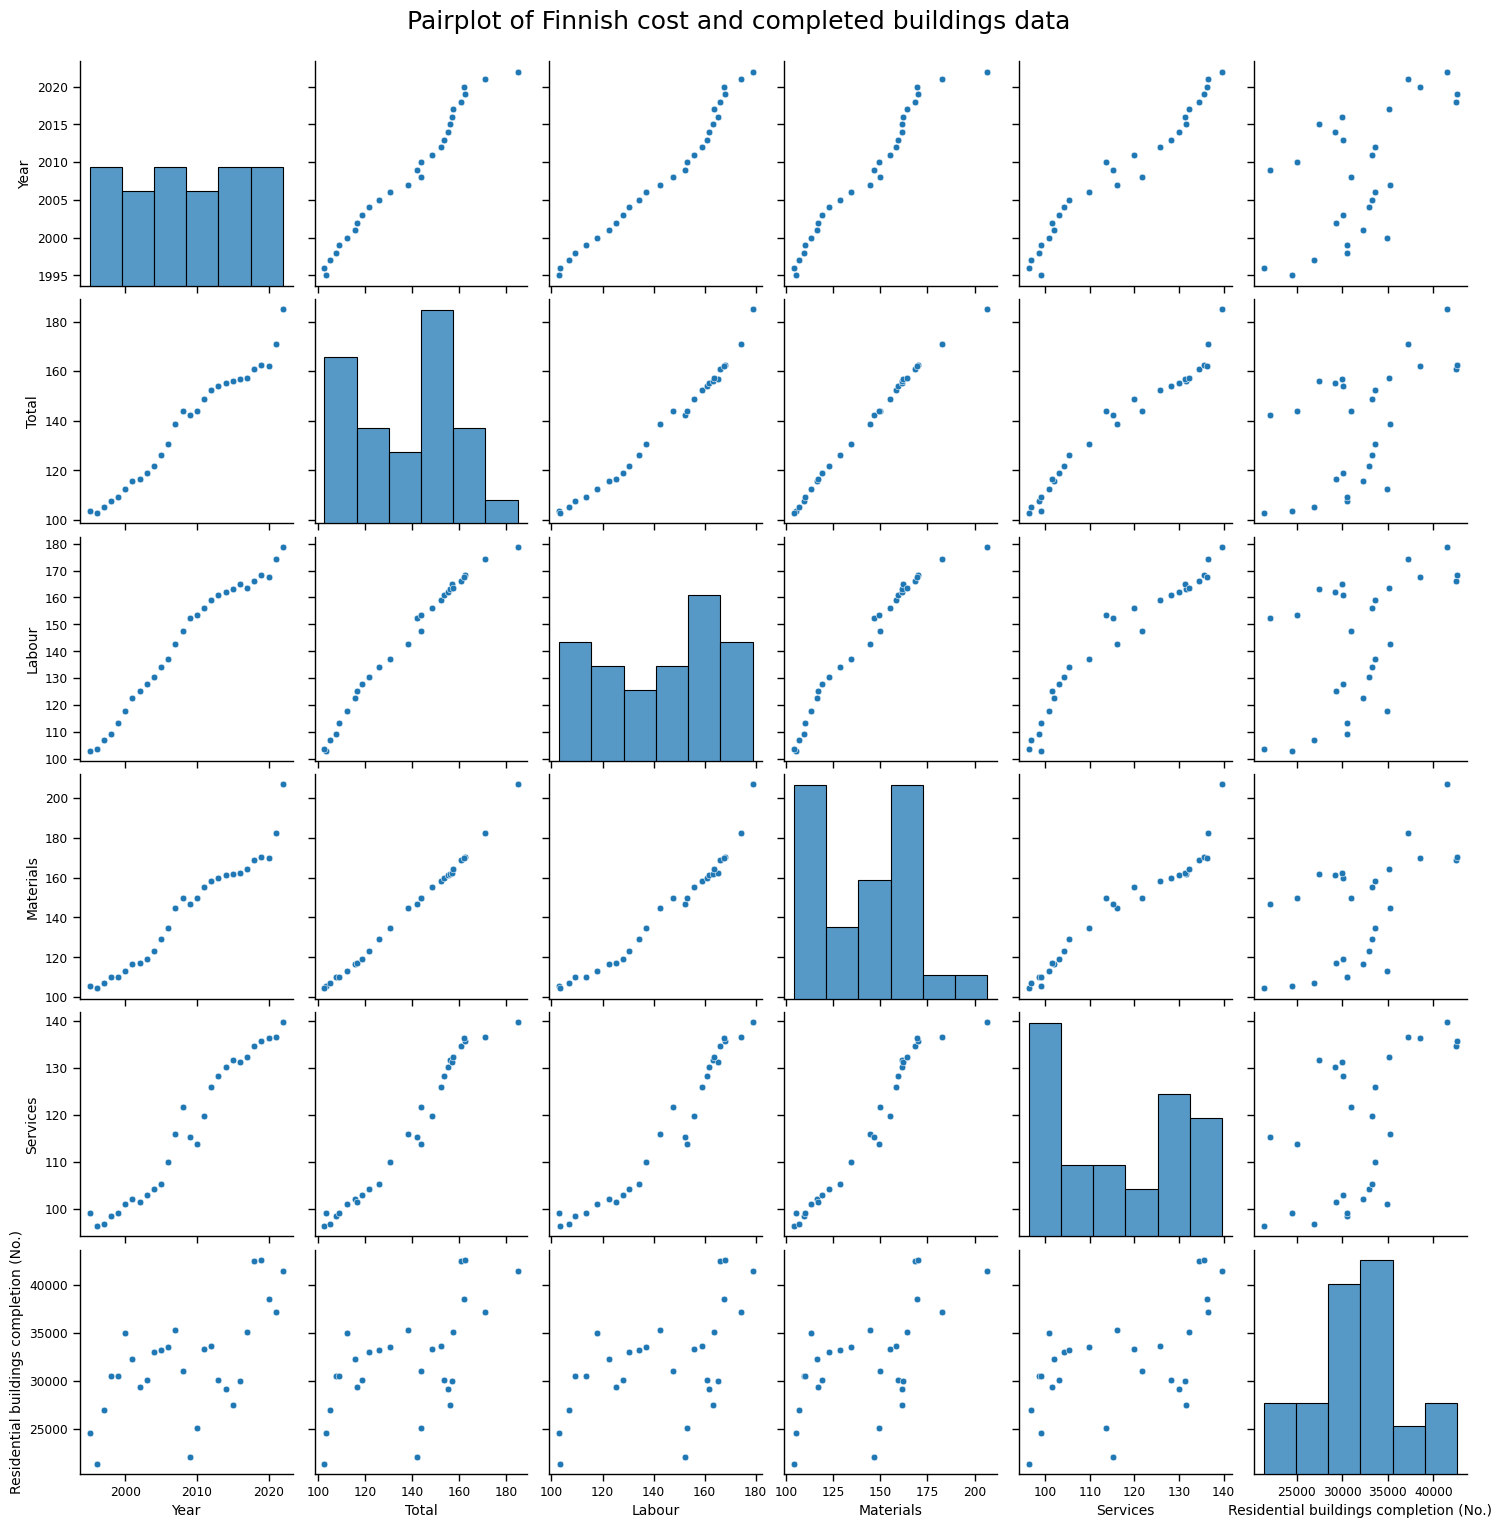

In [87]:
sns.set_context("paper", rc={"axes.labelsize":10})
g = sns.pairplot(finnish_data_combined)
g.fig.suptitle("Pairplot of Finnish cost and completed buildings data", y=1.02, fontsize=18)

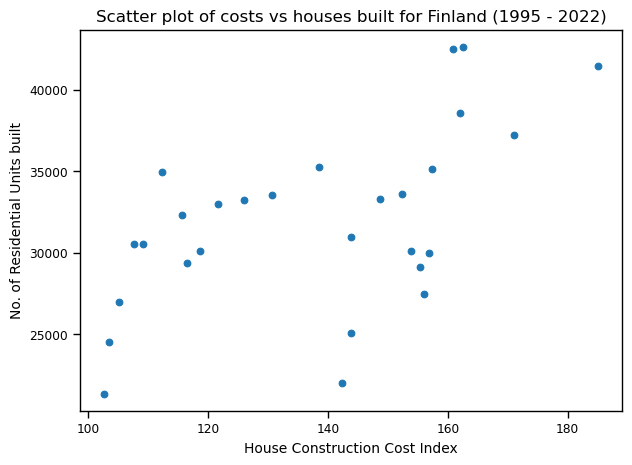

In [88]:
plt.figure(figsize=(7, 7/sqrt(2)))
plt.title("Scatter plot of costs vs houses built for Finland (1995 - 2022)", size=12)
plt.scatter(finnish_data_combined["Total"], finnish_data_combined["Residential buildings completion (No.)"])
plt.xlabel("House Construction Cost Index")
plt.ylabel("No. of Residential Units built")
#plt.scatter(X_train, y_predicted, c="red")
plt.show()

## Inferential statistics

### Irish data prep

In [89]:
irish_data_combined

,Quarter,House Construction Cost Index,No. of Units
0,q1_2018,212.513233,14816.0
1,q1_2019,214.525667,20324.0
2,q1_2021,218.490518,34511.0
3,q2_2018,213.003957,16351.0
4,q2_2019,215.117876,22139.0
5,q2_2020,216.901633,29810.0
6,q3_2018,213.509903,17536.0
7,q3_2019,215.614796,22721.0
8,q3_2020,217.476376,31862.0
9,q3_2021,219.630345,38174.0


In [90]:
finnish_data_combined

,Year,Total,Labour,Materials,Services,Residential buildings completion (No.)
0,1995,103.5,103.0,105.3,99.1,24526
1,1996,102.7,103.5,104.3,96.3,21372
2,1997,105.2,106.9,107.2,96.8,26955
3,1998,107.6,109.4,109.8,98.5,30529
4,1999,109.1,113.5,110.2,99.0,30537
5,2000,112.3,117.9,113.2,100.9,34960
6,2001,115.6,122.5,116.6,102.0,32306
7,2002,116.5,125.1,117.1,101.5,29354
8,2003,118.7,127.9,119.2,103.0,30082
9,2004,121.6,130.3,123.0,104.1,32972


In [91]:
#Create a Quarter variable in same format as completion data dataframe
irish_data_combined["Year"] = " "
for i in range(0,len(irish_data_combined)):
    try:
        year=irish_data_combined.Quarter[i][3:7]
        irish_data_combined["Year"][i] = int(year)
    except:
        print(year)

In [92]:
irish_data_combined_cost_index = irish_data_combined.drop(columns = ["No. of Units", "Quarter"])

In [93]:
irish_data_combined_cost_index.head()

,House Construction Cost Index,Year
0,212.513233,2018
1,214.525667,2019
2,218.490518,2021
3,213.003957,2018
4,215.117876,2019


In [94]:
irish_data_combined_units_built = irish_data_combined.drop(columns = ["House Construction Cost Index", "Quarter"])

In [95]:
irish_data_combined_units_built = irish_data_combined_units_built.groupby(["Year"], as_index = False).sum()

In [96]:
irish_data_combined_cost_index = irish_data_combined_cost_index.groupby(["Year"], as_index = False).sum()

In [97]:
irish_data_combined_cost_index

,Year,House Construction Cost Index
0,2018,853.115049
1,2019,861.267585
2,2020,652.338400
3,2021,438.120863


In [98]:
irish_data_combined_units_built

,Year,No. of Units
0,2018,67837.0
1,2019,91199.0
2,2020,95487.0
3,2021,72685.0


In [99]:
irish_data_combined_by_year = pd.merge(irish_data_combined_cost_index, irish_data_combined_units_built)

In [100]:
irish_data_combined_by_year

,Year,House Construction Cost Index,No. of Units
0,2018,853.115049,67837.0
1,2019,861.267585,91199.0
2,2020,652.338400,95487.0
3,2021,438.120863,72685.0


In [101]:
irish_data_combined_by_year["Population"] = [4830392, 4904240, 4964440, 5006324]

In [102]:
irish_data_combined_by_year

,Year,House Construction Cost Index,No. of Units,Population
0,2018,853.115049,67837.0,4830392
1,2019,861.267585,91199.0,4904240
2,2020,652.338400,95487.0,4964440
3,2021,438.120863,72685.0,5006324


In [103]:
irish_data_combined_by_year["cost_index_per_person"] = irish_data_combined_by_year["House Construction Cost Index"]/irish_data_combined_by_year["Population"]

In [104]:
irish_data_combined_by_year["units_built_per_person"] = irish_data_combined_by_year["No. of Units"]/irish_data_combined_by_year["Population"]

In [105]:
irish_data_combined_by_year

,Year,House Construction Cost Index,No. of Units,Population,cost_index_per_person,units_built_per_person
0,2018,853.115049,67837.0,4830392,0.000177,0.014044
1,2019,861.267585,91199.0,4904240,0.000176,0.018596
2,2020,652.338400,95487.0,4964440,0.000131,0.019234
3,2021,438.120863,72685.0,5006324,0.000088,0.014519


### Finnish

In [106]:
#finnish_data_combined[finnish_data_combined["Year"] >= 2018] and finnish_data_combined[finnish_data_combined["Year"] < 2022]

In [107]:
finnish_data_combined_subset = finnish_data_combined[finnish_data_combined["Year"] >= 2018]

In [108]:
finnish_data_combined_subset = finnish_data_combined_subset[finnish_data_combined["Year"] < 2022]

In [109]:
finnish_data_combined_subset

,Year,Total,Labour,Materials,Services,Residential buildings completion (No.)
23,2018,160.9,166.2,168.7,134.6,42456
24,2019,162.6,168.2,170.2,135.6,42602
25,2020,162.1,167.6,169.7,136.3,38543
26,2021,171.0,174.2,182.5,136.6,37216


In [110]:
finnish_data_combined_subset = finnish_data_combined_subset.drop(columns = ["Labour", "Materials", "Services"])

In [111]:
finnish_data_combined_subset

,Year,Total,Residential buildings completion (No.)
23,2018,160.9,42456
24,2019,162.6,42602
25,2020,162.1,38543
26,2021,171.0,37216


#### 1990 is index year for Finish dataset, January 1991 is the base year for Irish dataset. Finnish dataset will be reindexed to 1991 to match Irish dataset.

In [112]:
index1 = finnish_costs["Total"][finnish_costs["Year"] == 1990]
index2 = finnish_costs["Total"][finnish_costs["Year"] == 1991]
finnish_data_combined_subset["Total"] = (finnish_data_combined_subset["Total"]*index1[0])/index2[1]

In [113]:
finnish_data_combined_subset

,Year,Total,Residential buildings completion (No.)
23,2018,157.436399,42456
24,2019,159.099804,42602
25,2020,158.610568,38543
26,2021,167.318982,37216


In [114]:
finnish_data_combined_subset["Population"] = [5513130, 5517919, 5525292, 5533793]

In [115]:
finnish_data_combined_subset

,Year,Total,Residential buildings completion (No.),Population
23,2018,157.436399,42456,5513130
24,2019,159.099804,42602,5517919
25,2020,158.610568,38543,5525292
26,2021,167.318982,37216,5533793


In [116]:
finnish_data_combined_subset["cost_index_per_person"] = finnish_data_combined_subset["Total"]/finnish_data_combined_subset["Population"]

In [117]:
finnish_data_combined_subset["units_built_per_person"] = finnish_data_combined_subset["Residential buildings completion (No.)"]/finnish_data_combined_subset["Population"]

In [118]:
finnish_data_combined_subset

,Year,Total,Residential buildings completion (No.),Population,cost_index_per_person,units_built_per_person
23,2018,157.436399,42456,5513130,0.000029,0.007701
24,2019,159.099804,42602,5517919,0.000029,0.007721
25,2020,158.610568,38543,5525292,0.000029,0.006976
26,2021,167.318982,37216,5533793,0.000030,0.006725


### Tests

#### Shapiro-Wilk test for normality

In [119]:
#Shapiro-Wilk
#H0: The Finnish construction data is normally distributed.

print(shapiro(finnish_data_combined_subset['cost_index_per_person']))
print(shapiro(finnish_data_combined_subset['units_built_per_person']))

#ShapiroResult(statistic=0.7628631591796875, pvalue=0.050590015947818756)
#ShapiroResult(statistic=0.8392341732978821, pvalue=0.19317929446697235)

#Null-hypothesis is retained in both cases

ShapiroResult(statistic=0.7628631591796875, pvalue=0.050590015947818756)
ShapiroResult(statistic=0.8392341732978821, pvalue=0.19317929446697235)


In [120]:
#Shapiro-Wilk
#H0: The Finnish construction data is normally distributed.

print(shapiro(irish_data_combined_by_year['cost_index_per_person']))
print(shapiro(irish_data_combined_by_year['units_built_per_person']))

#ShapiroResult(statistic=0.8701202869415283, pvalue=0.2981545627117157)
#ShapiroResult(statistic=0.827171802520752, pvalue=0.16054634749889374)

#Null-hypothesis is retained in both cases

ShapiroResult(statistic=0.8701202869415283, pvalue=0.2981545627117157)
ShapiroResult(statistic=0.827171802520752, pvalue=0.16054634749889374)


#### Levene's test for homogeneity of variances

In [121]:
# null hypothesis: the variances are equal across the samples
stats.levene(finnish_data_combined_subset['units_built_per_person'],
             irish_data_combined_by_year['units_built_per_person'])

#Null hypothesis rejected (LeveneResult(statistic=116.09229911403482, pvalue=3.7792832471135456e-05))

LeveneResult(statistic=116.09229911403482, pvalue=3.7792832471135456e-05)

In [122]:
# null hypothesis: the variances are equal across the samples
stats.levene(finnish_data_combined_subset['cost_index_per_person'],
             irish_data_combined_by_year['cost_index_per_person'])

#Null hypothesis rejected (LeveneResult(statistic=9.102961841762506, pvalue=0.02348431386213081))

LeveneResult(statistic=9.102961841762506, pvalue=0.02348431386213081)

#### T-tests (assuming the data fits the assumptions for normailty, which it does not due to homegeneity of variances)

In [123]:
print(f"Finnish units constructed per capita: {mean(finnish_data_combined_subset['units_built_per_person'])}")
print(f"Irish units constructed per capita: {mean(irish_data_combined_by_year['units_built_per_person'])}")

Finnish units constructed per capita: 0.007280629310257464
Irish units constructed per capita: 0.016598141947683845


In [124]:
print(f"Irish construction costs per capita: {mean(finnish_data_combined_subset['cost_index_per_person'])}")
print(f"Irish construction costs per capita: {mean(irish_data_combined_by_year['cost_index_per_person'])}")

Irish construction costs per capita: 2.908301552215005e-05
Irish construction costs per capita: 0.00014278666777512304


In [125]:
# Null hypothesis that the difference in group means is zero 
stats.ttest_ind(finnish_data_combined_subset['cost_index_per_person'], irish_data_combined_by_year['cost_index_per_person'])

# Null hypothesis rejected (Ttest_indResult(statistic=-5.355749593114567, pvalue=0.0017351048198945788))

Ttest_indResult(statistic=-5.355749593114567, pvalue=0.0017351048198945788)

In [126]:
# Null hypothesis that the difference in group means is zero
res = pg.ttest(finnish_data_combined_subset['cost_index_per_person'], irish_data_combined_by_year['cost_index_per_person'], paired=False)
print(res)

              T  dof alternative     p-val         CI95%   cohen-d    BF10  \
T-test -5.35575    6   two-sided  0.001735  [-0.0, -0.0]  3.787087  17.319   

           power  
T-test  0.992426  


In [127]:
# Null hypothesis that the difference in group means is zero 
stats.ttest_ind(finnish_data_combined_subset['units_built_per_person'], irish_data_combined_by_year['units_built_per_person'])

# Null hypothesis rejected (Ttest_indResult(statistic=-6.795381344913097, pvalue=0.0004972118035479912))

Ttest_indResult(statistic=-6.795381344913097, pvalue=0.0004972118035479912)

In [128]:
# Null hypothesis that the difference in group means is zero
res = pg.ttest(finnish_data_combined_subset['units_built_per_person'], irish_data_combined_by_year['units_built_per_person'], paired=False)
print(res)

               T  dof alternative     p-val           CI95%  cohen-d    BF10  \
T-test -6.795381    6   two-sided  0.000497  [-0.01, -0.01]  4.80506  43.542   

          power  
T-test  0.99981  


#### Mann-Whitney U Test for non-parametric data (due to homegeneity of variances assumpion having failed)

In [129]:
# null hypothesis: the distribution underlying the samples is the same
stats.mannwhitneyu(finnish_data_combined_subset['cost_index_per_person'], irish_data_combined_by_year['cost_index_per_person'])

# null hypothesis rejected (MannwhitneyuResult(statistic=0.0, pvalue=0.02857142857142857))

MannwhitneyuResult(statistic=0.0, pvalue=0.02857142857142857)

In [130]:
# null hypothesis: the distribution underlying the samples is the same
stats.mannwhitneyu(finnish_data_combined_subset['units_built_per_person'], irish_data_combined_by_year['units_built_per_person'])

# null hypothesis rejected (MannwhitneyuResult(statistic=0.0, pvalue=0.02857142857142857))

MannwhitneyuResult(statistic=0.0, pvalue=0.02857142857142857)

## Dashboard

In [131]:
finnish_data_combined_subset["Country"] = "Finland"

In [132]:
irish_data_combined_by_year["Country"] = "Ireland"

In [133]:
combined_data = pd.concat([finnish_data_combined_subset, irish_data_combined_by_year]) #, on = ["Year"], suffixes=('_finnish', '_irish'))

In [134]:
combined_data

,Year,Total,Residential buildings completion (No.),Population,cost_index_per_person,units_built_per_person,Country,House Construction Cost Index,No. of Units
23,2018,157.436399,42456.0,5513130,0.000029,0.007701,Finland,NaN,NaN
24,2019,159.099804,42602.0,5517919,0.000029,0.007721,Finland,NaN,NaN
25,2020,158.610568,38543.0,5525292,0.000029,0.006976,Finland,NaN,NaN
26,2021,167.318982,37216.0,5533793,0.000030,0.006725,Finland,NaN,NaN
0,2018,NaN,NaN,4830392,0.000177,0.014044,Ireland,853.115049,67837.0
1,2019,NaN,NaN,4904240,0.000176,0.018596,Ireland,861.267585,91199.0
2,2020,NaN,NaN,4964440,0.000131,0.019234,Ireland,652.338400,95487.0
3,2021,NaN,NaN,5006324,0.000088,0.014519,Ireland,438.120863,72685.0


In [150]:
app = dash.Dash(__name__)

colors = {
    'background': '#111111',
    'text': '#7FDBFF'
}

fig = px.bar(combined_data, x="Year", y="cost_index_per_person", color="Country", color_discrete_map={
        'Finland': 'blue', 'Ireland': 'green'}, barmode="group", title="Cost Index per Capita",
             labels={"cost_index_per_person": "Cost Index per person"}, hover_data=[combined_data.Population])

fig2 = px.bar(combined_data, x="Year", y="units_built_per_person", color="Country", color_discrete_map={
        'Finland': 'blue', 'Ireland': 'green'}, barmode="group", title="Units built per Capita",
              labels={"units_built_per_person": "Units build per person"}, hover_data=[combined_data.Population])

fig.update_layout(
    plot_bgcolor=colors['background'],
    paper_bgcolor=colors['background'],
    font_color=colors['text'], bargap=0.05
)

fig2.update_layout(
    plot_bgcolor=colors['background'],
    paper_bgcolor=colors['background'],
    font_color=colors['text']
)

app.layout = html.Div(style={'backgroundColor': colors['background']},children=[
   # elements from the top of the page
   html.Div([
      html.H1(children='Cost Index', style={
            'textAlign': 'center',
            'color': colors['text']
        }),
      html.Div(children=''),

      dcc.Graph(
         id='graph1',
         figure=fig),
            
   ]),
   # New Div for all elements in the new 'row' of the page
   html.Div([
      html.H1(children='Residential units built', style={
            'textAlign': 'center',
            'color': colors['text']
        }),
      html.Div(children=''),

      dcc.Graph(
         id='graph2',
         figure=fig2),
   ]),
])

if __name__ == '__main__':
    app.run_server()

Dash is running on http://127.0.0.1:8050/

 * Serving Flask app "__main__" (lazy loading)
 * Environment: production
   Use a production WSGI server instead.
 * Debug mode: off


 * Running on http://127.0.0.1:8050/ (Press CTRL+C to quit)
127.0.0.1 - - [21/May/2023 17:25:05] "GET / HTTP/1.1" 200 -
127.0.0.1 - - [21/May/2023 17:25:05] "GET /_dash-layout HTTP/1.1" 200 -
127.0.0.1 - - [21/May/2023 17:25:05] "GET /_dash-dependencies HTTP/1.1" 200 -
127.0.0.1 - - [21/May/2023 17:25:05] "GET /_dash-component-suites/dash/dcc/async-graph.js HTTP/1.1" 304 -
127.0.0.1 - - [21/May/2023 17:25:05] "GET /_dash-component-suites/dash/dcc/async-plotlyjs.js HTTP/1.1" 304 -


## Saving combined data to file

In [139]:
irish_data_combined.to_csv('irish_data_combined.csv')
finnish_data_combined.to_csv('finnish_data_combined.csv')

### References

https://towardsdatascience.com/time-series-forecasting-with-machine-learning-b3072a5b44ba

https://machinelearningmastery.com/time-series-data-visualization-with-python/

https://www.simplilearn.com/tutorials/python-tutorial/time-series-analysis-in-python

https://www.educative.io/answers/what-is-autocorrelation-in-python

https://online.stat.psu.edu/stat462/node/188/

https://machinelearningmastery.com/arima-for-time-series-forecasting-with-python/

https://www.statology.org/dickey-fuller-test-python/

https://medium.com/analytics-vidhya/arima-fc1f962c22d4

https://www.projectpro.io/recipes/do-cross-validation-for-time-series

https://ec.europa.eu/eurostat/databrowser/view/TPS00001/default/table?lang=en

https://www.graphpad.com/support/faq/how-do-i-evaluate-if-my-data-meet-necessary-assumptions-before-applying-parametric-tests/

https://www.marsja.se/how-to-perform-a-two-sample-t-test-with-python-3-different-methods/

https://www.pythonfordatascience.org/parametric-assumptions-python/

https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.mannwhitneyu.html

https://dash.plotly.com/layout

https://plotly.com/python/px-arguments/

https://plotly.com/python/figure-labels/

https://www.tutorialspoint.com/how-to-add-multiple-graphs-to-a-plotly-dash-app-on-a-single-browser-page-in-python-plotly

https://community.plotly.com/t/plotly-express-bar-colour-change/36210/3